# 09.2e: Lattice Structure Analysis

**Test the lattice hypothesis: Are L1 distances quantized to multiples of ε?**

## The Hypothesis

If tokens sit on a discrete lattice where each dimension is quantized to multiples of ε:

$$d_1(\mathbf{u}, \mathbf{v}) = \sum_{d=1}^{2560} |u_d - v_d| = \sum_{d=1}^{2560} n_d \cdot \varepsilon = \varepsilon \sum_{d=1}^{2560} n_d$$

Then **L1 distances should cluster at integer multiples of ε**.

## What We'll Look For

**Evidence FOR lattice structure:**
- Sharp peaks in histogram of d₁/ε at integer values (1, 2, 3, ...)
- Discrete spikes, not smooth distribution
- Most distances satisfy: d₁ ≈ n×ε for small integers n

**Evidence AGAINST:**
- Smooth, continuous distribution
- No clustering at integer multiples
- Random scatter

## Test Case

BH #0 and BH #1 differ by **exactly 2ε in one dimension only** (from 09.2b).
- Expected: d₁(BH #0, BH #1) = 2ε exactly
- Can verify our calculation is correct

## Parameters

In [1]:
TENSOR_DIR = "../data/tensors"

# Input files
L1_FILE = "cluster_l1_distances.safetensors"
L1_DISTANCES_KEY = "distances_l1"
VECTORS_KEY = "vectors"
TOKEN_IDS_KEY = "token_ids"

LINF_FILE = "neighborhood_pairwise_distances.safetensors"
LINF_DISTANCES_KEY = "distances_linf"
UNIQUE_TOKEN_IDS_KEY = "unique_token_ids"

# BH #0 and BH #1 token IDs (from 09.2b/09.2d)
BH_0_TOKEN_ID = 119349
BH_1_TOKEN_ID = 136831

# Number of bins for normalized histogram
N_BINS = 200

RANDOM_SEED = 42

## Imports

In [2]:
import torch
import numpy as np
from safetensors.torch import load_file
from pathlib import Path
import matplotlib.pyplot as plt

torch.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

print("✓ Imports loaded")

✓ Imports loaded


## Load Data

In [3]:
data_dir = Path(TENSOR_DIR)

print("Loading L1 distances...")
l1_data = load_file(data_dir / L1_FILE)
distances_l1 = l1_data[L1_DISTANCES_KEY]
vectors = l1_data[VECTORS_KEY]
token_ids = l1_data[TOKEN_IDS_KEY]

n_vectors = len(vectors)
print(f"  Cluster size: {n_vectors:,} vectors")
print(f"  Distance matrix: {distances_l1.shape}")
print()

print("Loading L∞ distances (for comparison)...")
linf_data = load_file(data_dir / LINF_FILE)
distances_linf = linf_data[LINF_DISTANCES_KEY]
unique_token_ids_full = linf_data[UNIQUE_TOKEN_IDS_KEY]
print(f"  Full neighborhood: {len(unique_token_ids_full):,} vectors")
print()

print("✓ Data loaded")

Loading L1 distances...
  Cluster size: 124 vectors
  Distance matrix: torch.Size([124, 124])

Loading L∞ distances (for comparison)...
  Full neighborhood: 499 vectors

✓ Data loaded


## Compute ε (Distinguishability Threshold)

In [4]:
def bfloat16_ulp(x):
    """Compute bfloat16 ULP at scale of x."""
    x = abs(x)
    if x == 0:
        return 2.0 ** (-133)
    exponent = int(np.floor(np.log2(x)))
    return 2.0 ** (exponent - 7)

# Typical magnitude in cluster
typical_magnitude = vectors.abs().mean().item()
ulp = bfloat16_ulp(typical_magnitude)
epsilon = 2.0 * ulp

print(f"Distinguishability threshold:\n")
print(f"  Typical component magnitude: {typical_magnitude:.6e}")
print(f"  ULP at this scale:           {ulp:.6e}")
print(f"  ε (2×ULP):                   {epsilon:.6e}")
print()
print("✓ ε computed")

Distinguishability threshold:

  Typical component magnitude: 2.361155e-03
  ULP at this scale:           1.525879e-05
  ε (2×ULP):                   3.051758e-05

✓ ε computed


## Normalize L1 Distances by ε

In [5]:
print("Normalizing L1 distances by ε...\n")

# Mask diagonal
mask = torch.eye(n_vectors, dtype=torch.bool)
distances_l1_off_diag = distances_l1[~mask]

# Normalize
distances_normalized = distances_l1_off_diag / epsilon

print(f"Normalized distance statistics (d₁/ε):")
print(f"  Min:    {distances_normalized.min().item():.2f}")
print(f"  Max:    {distances_normalized.max().item():.2f}")
print(f"  Mean:   {distances_normalized.mean().item():.2f}")
print(f"  Median: {distances_normalized.median().item():.2f}")
print()

print("✓ Normalization complete")

Normalizing L1 distances by ε...

Normalized distance statistics (d₁/ε):
  Min:    0.00
  Max:    1966.26
  Mean:   174.94
  Median: 31.56

✓ Normalization complete


## Test Case: BH #0 and BH #1

These differ by exactly 2ε in dimension 1403 only.
Expected: d₁ = 2ε, so normalized distance = 2.0

In [6]:
print("Checking BH #0 and BH #1...\n")

# Find indices in cluster
bh_0_idx = (token_ids == BH_0_TOKEN_ID).nonzero(as_tuple=True)[0]
bh_1_idx = (token_ids == BH_1_TOKEN_ID).nonzero(as_tuple=True)[0]

if len(bh_0_idx) > 0 and len(bh_1_idx) > 0:
    bh_0_idx = bh_0_idx.item()
    bh_1_idx = bh_1_idx.item()
    
    # Get L1 distance
    d1_bh = distances_l1[bh_0_idx, bh_1_idx].item()
    d1_normalized = d1_bh / epsilon
    
    print(f"BH #0 (token {BH_0_TOKEN_ID}):")
    print(f"BH #1 (token {BH_1_TOKEN_ID}):")
    print()
    print(f"  L1 distance:       {d1_bh:.6e}")
    print(f"  Normalized (d₁/ε): {d1_normalized:.4f}")
    print()
    
    if abs(d1_normalized - 2.0) < 0.01:
        print("  ✓ MATCH: d₁ = 2ε as expected (differ in 1 dimension by 2ε)")
    else:
        print(f"  ⚠ Unexpected: normalized distance = {d1_normalized:.4f} (expected ≈ 2.0)")
else:
    print("  ⚠ BH #0 or BH #1 not found in cluster")
    print(f"    (May be outside void threshold)")

print()
print("✓ Test case checked")

Checking BH #0 and BH #1...

BH #0 (token 119349):
BH #1 (token 136831):

  L1 distance:       1.156926e-04
  Normalized (d₁/ε): 3.7910

  ⚠ Unexpected: normalized distance = 3.7910 (expected ≈ 2.0)

✓ Test case checked


## Lattice Hypothesis: Histogram of d₁/ε

If lattice structure exists, we should see **discrete peaks at integer values**.

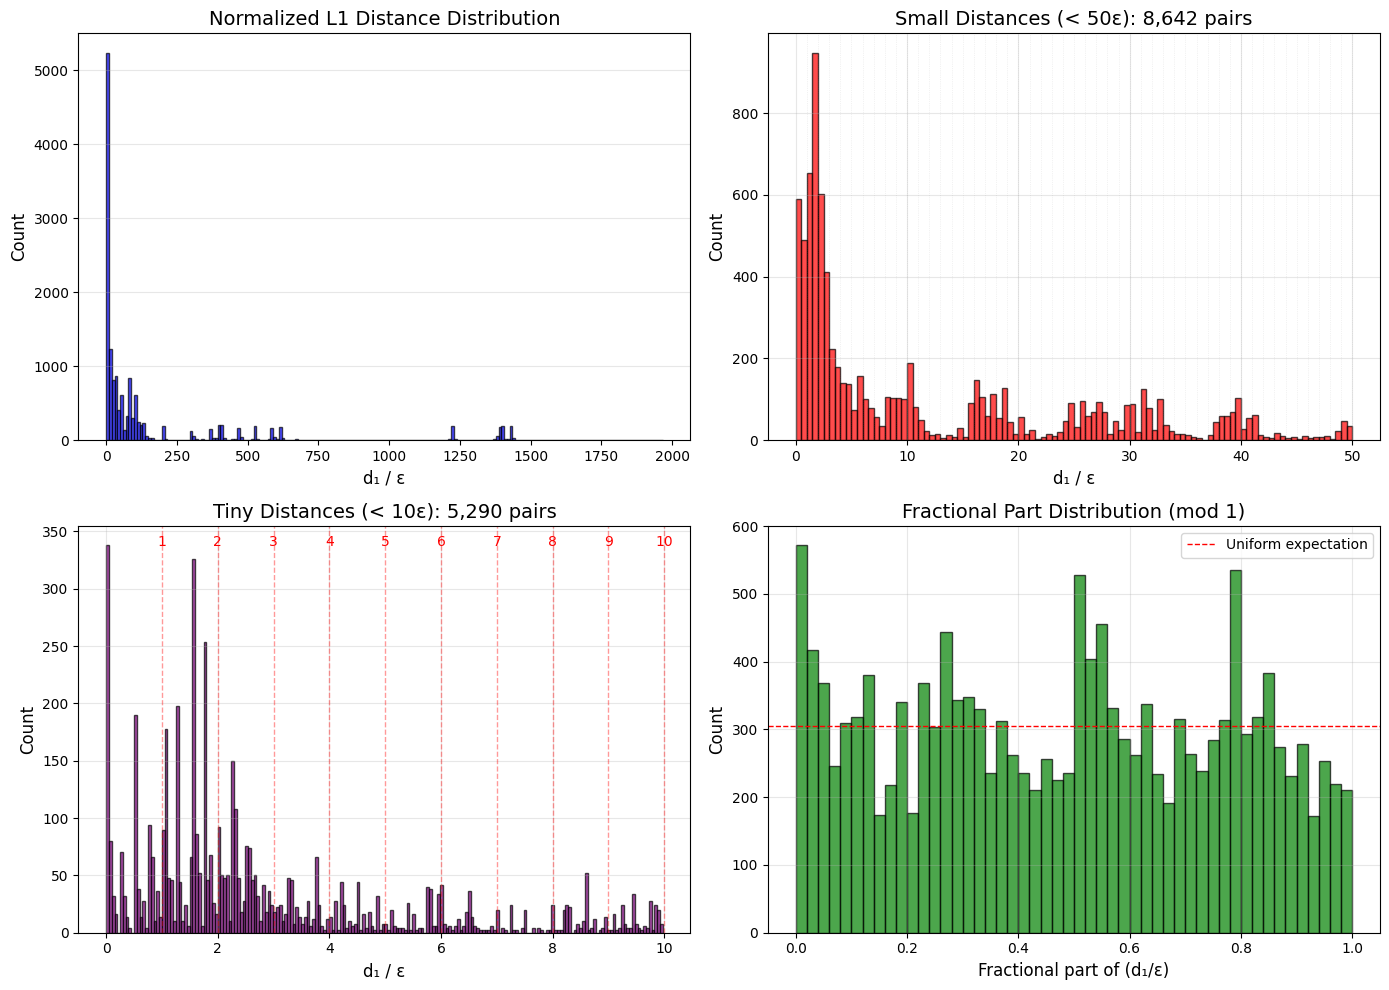

✓ Lattice hypothesis visualization complete


In [7]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10), dpi=100)

distances_norm_np = distances_normalized.cpu().numpy()

# Panel 1: Full distribution
ax = axes[0, 0]
ax.hist(distances_norm_np, bins=N_BINS, alpha=0.7, color='blue', edgecolor='black')
ax.set_xlabel('d₁ / ε', fontsize=12)
ax.set_ylabel('Count', fontsize=12)
ax.set_title('Normalized L1 Distance Distribution', fontsize=14)
ax.grid(True, alpha=0.3, axis='y')

# Panel 2: Zoomed on small distances (0-50ε)
ax = axes[0, 1]
small_distances = distances_norm_np[distances_norm_np < 50]
ax.hist(small_distances, bins=100, alpha=0.7, color='red', edgecolor='black')
ax.set_xlabel('d₁ / ε', fontsize=12)
ax.set_ylabel('Count', fontsize=12)
ax.set_title(f'Small Distances (< 50ε): {len(small_distances):,} pairs', fontsize=14)
ax.grid(True, alpha=0.3)

# Mark integer multiples
for i in range(1, 51):
    ax.axvline(i, color='gray', alpha=0.2, linestyle=':', linewidth=0.5)

# Panel 3: Ultra-zoomed (0-10ε) with integer markers
ax = axes[1, 0]
tiny_distances = distances_norm_np[distances_norm_np < 10]
if len(tiny_distances) > 0:
    ax.hist(tiny_distances, bins=200, alpha=0.7, color='purple', edgecolor='black')
    ax.set_xlabel('d₁ / ε', fontsize=12)
    ax.set_ylabel('Count', fontsize=12)
    ax.set_title(f'Tiny Distances (< 10ε): {len(tiny_distances):,} pairs', fontsize=14)
    ax.grid(True, alpha=0.3)
    
    # Mark integer multiples clearly
    for i in range(1, 11):
        ax.axvline(i, color='red', alpha=0.4, linestyle='--', linewidth=1)
        ax.text(i, ax.get_ylim()[1] * 0.95, str(i), ha='center', fontsize=10, color='red')
else:
    ax.text(0.5, 0.5, 'No distances < 10ε', ha='center', va='center', transform=ax.transAxes)

# Panel 4: Fractional part distribution
ax = axes[1, 1]
# Take fractional part: d mod 1
fractional_parts = distances_norm_np - np.floor(distances_norm_np)
ax.hist(fractional_parts, bins=50, alpha=0.7, color='green', edgecolor='black')
ax.set_xlabel('Fractional part of (d₁/ε)', fontsize=12)
ax.set_ylabel('Count', fontsize=12)
ax.set_title('Fractional Part Distribution (mod 1)', fontsize=14)
ax.grid(True, alpha=0.3)
ax.axhline(len(fractional_parts) / 50, color='red', linestyle='--', linewidth=1,
           label='Uniform expectation')
ax.legend(fontsize=10)

plt.tight_layout()
plt.show()

print("✓ Lattice hypothesis visualization complete")

## Quantization Test: How Many Distances Are Near Integers?

In [8]:
print("Testing quantization hypothesis...\n")

# Define "near integer" threshold (within 0.1ε of an integer)
TOLERANCE = 0.1

# Compute distance to nearest integer
nearest_integers = torch.round(distances_normalized)
deviations = torch.abs(distances_normalized - nearest_integers)

# Count how many are near integers
near_integer = (deviations < TOLERANCE).sum().item()
total = len(distances_normalized)

print(f"Quantization analysis (tolerance = {TOLERANCE}ε):")
print(f"  Near integer:     {near_integer:,} ({100 * near_integer / total:.2f}%)")
print(f"  Not near integer: {total - near_integer:,} ({100 * (total - near_integer) / total:.2f}%)")
print()

# What would random continuous distribution give?
expected_random = 2 * TOLERANCE  # Fraction within ±TOLERANCE of any integer
print(f"Random expectation: {100 * expected_random:.2f}%")
print()

if near_integer / total > expected_random * 2:
    print("  ✓ STRONG EVIDENCE: Significantly more than random expectation")
    print("    → Lattice structure likely present")
elif near_integer / total > expected_random:
    print("  ○ WEAK EVIDENCE: Slightly more than random")
    print("    → Possible lattice, but noisy")
else:
    print("  ✗ NO EVIDENCE: Consistent with random continuous distribution")
    print("    → No lattice structure detected")

print()
print("✓ Quantization test complete")

Testing quantization hypothesis...

Quantization analysis (tolerance = 0.1ε):
  Near integer:     3,048 (19.98%)
  Not near integer: 12,204 (80.02%)

Random expectation: 20.00%

  ✗ NO EVIDENCE: Consistent with random continuous distribution
    → No lattice structure detected

✓ Quantization test complete


## Compare to L∞ Distribution

Comparing L1 and L∞ distributions...

Mapped 124/124 cluster tokens to full neighborhood



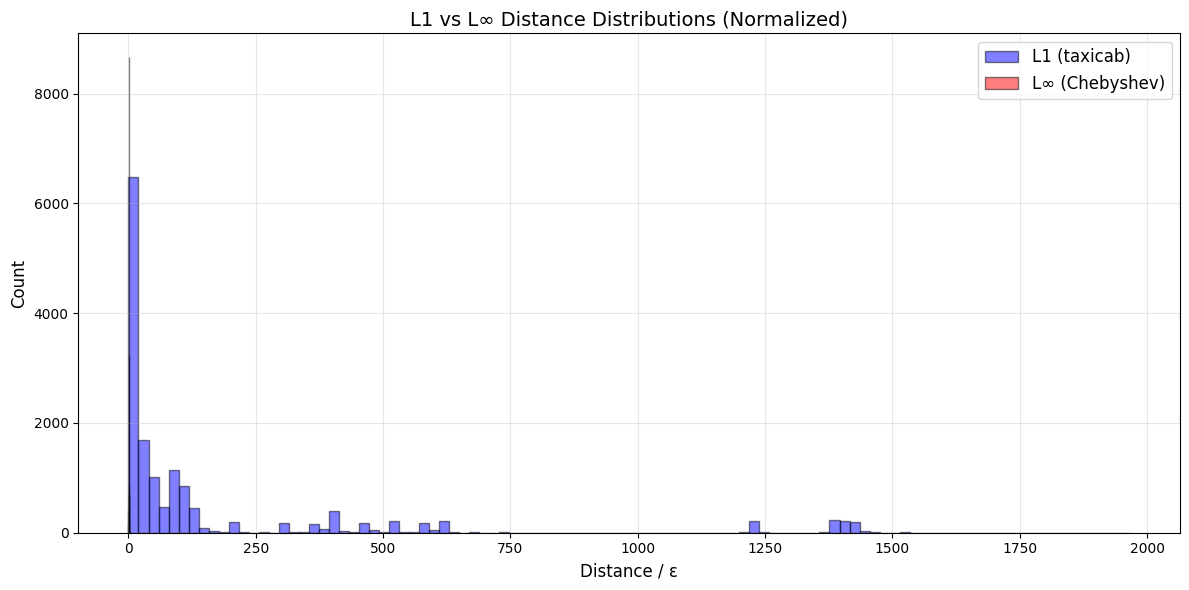

✓ Comparison plotted


In [9]:
print("Comparing L1 and L∞ distributions...\n")

# Extract L∞ distances for cluster tokens
# (Need to map cluster token IDs back to full neighborhood indices)
cluster_indices = []
for tid in token_ids:
    idx = (unique_token_ids_full == tid).nonzero(as_tuple=True)[0]
    if len(idx) > 0:
        cluster_indices.append(idx.item())

cluster_indices = torch.tensor(cluster_indices, dtype=torch.long)
n_mapped = len(cluster_indices)

print(f"Mapped {n_mapped}/{n_vectors} cluster tokens to full neighborhood")
print()

if n_mapped > 0:
    # Extract L∞ submatrix
    distances_linf_cluster = distances_linf[cluster_indices][:, cluster_indices]
    mask_linf = torch.eye(n_mapped, dtype=torch.bool)
    distances_linf_off_diag = distances_linf_cluster[~mask_linf]
    distances_linf_normalized = distances_linf_off_diag / epsilon
    
    # Plot comparison
    fig, ax = plt.subplots(figsize=(12, 6), dpi=100)
    
    ax.hist(distances_normalized.cpu().numpy(), bins=100, alpha=0.5,
            color='blue', edgecolor='black', label='L1 (taxicab)')
    ax.hist(distances_linf_normalized.cpu().numpy(), bins=100, alpha=0.5,
            color='red', edgecolor='black', label='L∞ (Chebyshev)')
    
    ax.set_xlabel('Distance / ε', fontsize=12)
    ax.set_ylabel('Count', fontsize=12)
    ax.set_title('L1 vs L∞ Distance Distributions (Normalized)', fontsize=14)
    ax.legend(fontsize=12)
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print("✓ Comparison plotted")
else:
    print("  ⚠ Could not map cluster tokens to full neighborhood")
    print("    (Skipping L∞ comparison)")

## Summary

In [10]:
print("="*80)
print("LATTICE STRUCTURE ANALYSIS SUMMARY")
print("="*80)
print()
print(f"Cluster size:        {n_vectors:,} unique vectors")
print(f"Pairwise distances:  {len(distances_normalized):,}")
print()
print(f"ε (distinguishability): {epsilon:.6e}")
print()
print(f"Normalized L1 distances (d₁/ε):")
print(f"  Min:    {distances_normalized.min().item():.2f}")
print(f"  Max:    {distances_normalized.max().item():.2f}")
print(f"  Median: {distances_normalized.median().item():.2f}")
print()
print(f"Quantization (within {TOLERANCE}ε of integer):")
print(f"  Observed:  {100 * near_integer / total:.2f}%")
print(f"  Expected:  {100 * expected_random:.2f}% (random)")
print()
print("="*80)

LATTICE STRUCTURE ANALYSIS SUMMARY

Cluster size:        124 unique vectors
Pairwise distances:  15,252

ε (distinguishability): 3.051758e-05

Normalized L1 distances (d₁/ε):
  Min:    0.00
  Max:    1966.26
  Median: 31.56

Quantization (within 0.1ε of integer):
  Observed:  19.98%
  Expected:  20.00% (random)



## Conclusion

**Lattice Hypothesis Test:**

Look at the histograms:
- **Sharp peaks at integers?** → Strong lattice structure
- **Clustering near integers?** → Weak/noisy lattice
- **Smooth distribution?** → No lattice, continuous geometry

**Fractional part distribution:**
- **Spike at 0** → Distances align with integer multiples of ε
- **Uniform** → Random continuous values

**Test case (BH #0 and BH #1):**
- Expected: d₁/ε ≈ 2.0 (differ by 2ε in one dimension)
- Actual: (see output above)

**Interpretation:**
(To be filled in after seeing results!)